In [23]:
import time

import numpy as np
import matplotlib.pyplot as plt

# from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms
from torchvision.datasets import CIFAR10

In [24]:
# Mini-Batch Gradient Descent
batch_size = 128

learning_rate = 0.1
num_epochs = 100
num_classes = 10

# the percentage of the training dataset to use as validation dataset
valid_percentage = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("now using device: ", device)

classes = (
    "Airplane",
    "Car",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
)

now using device:  cuda


## 网络结构

![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*JEGNYy9rXMj_XN7W1Qjo9g.png)
![](https://img-blog.csdnimg.cn/20200104153325358.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2p1c3Rfc29ydA==,size_16,color_FFFFFF,t_70)

![](https://img-blog.csdnimg.cn/20200104162456690.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2p1c3Rfc29ydA==,size_16,color_FFFFFF,t_70)


```
    Input
      |
   Conv Layer
      |
   ReLU
      |
   Conv Layer
      |
      |----------------
      |               |
     ReLU             |
      |               |
     Output          Input
      |               |
      ----------------
           |
         Output
```


In [25]:
def conv3x3(in_channels, out_channels, stride=1):
    # 二维卷积层
    # in_channels：输入特征图的通道数。例如，对于RGB图像，in_channels为3。
    # out_channels：输出特征图的通道数。这个值决定了卷积核的数量，即我们希望提取多少个特征。
    # kernel_size：卷积核的大小，可以是一个整数或一个元组。例如，kernel_size=3表示使用3x3的卷积核。
    # stride：卷积核的步幅，决定卷积核在输入特征图上移动的步长。默认值为1。
    # padding：填充方式，为了保持特征图的尺寸，可以在输入特征图的边缘填充0。padding=1表示在所有边缘填充1个像素。
    # bias：是否添加偏置项。默认值为True。这里不使用偏置项（bias=False），因为后面有批量归一化层。
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False
    )


class BasicBlock(nn.Module):
    """
    A basic residual block for ResNet.

    Attributes:
        conv1: First convolutional layer.
        bn1: Batch normalization for the first convolutional layer.
        conv2: Second convolutional layer.
        bn2: Batch normalization for the second convolutional layer.
        shortcut: Shortcut connection to match input and output dimensions.
    """

    expansion: int = (
        1  # 输出通道数相对于输入通道数的扩展倍数。对于基本块，扩展倍数为1。
    )

    def __init__(self, in_channels, out_channels, stride=1):
        """
        Initializes the basic block.

        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            stride: Stride for the convolution. Default is 1.
        """
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(in_channels, out_channels, stride)
        # 对卷积层的输出进行归一化处理。这有助于加速训练并稳定模型。
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        # 在残差块中，如果输入和输出的形状不一致（例如通道数不同或步幅不为1），我们需要通过一个卷积层来调整输入的形状，使其与输出形状一致。
        if stride != 1 or in_channels != out_channels:
            # 如果需要，则定义一个包含1x1卷积层和批量归一化层的顺序容器。
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            x: Input tensor.

        Returns:
            Output tensor.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# Example usage
# Define an input tensor with shape (batch_size, in_channels, height, width)
x = torch.randn(1, 64, 32, 32)
# Create a basic block instance
block = BasicBlock(64, 64)
# Forward pass
out = block(x)
print(out.shape)

torch.Size([1, 64, 32, 32])


```
    Input
      |
   1x1 Conv (Reduction)
      |
   BatchNorm
      |
    ReLU
      |
   3x3 Conv
      |
   BatchNorm
      |
    ReLU
      |
   1x1 Conv (Expansion)
      |
   BatchNorm
      |----------------
      |               |
     ReLU             |
      |               |
     Output          Input
      |               |
      ----------------
           |
         Output
```


In [26]:
class Bottleneck(nn.Module):
    """
    A bottleneck residual block for ResNet.

    Attributes:
        conv1: First convolutional layer (1x1).
        bn1: Batch normalization for the first convolutional layer.
        conv2: Second convolutional layer (3x3).
        bn2: Batch normalization for the second convolutional layer.
        conv3: Third convolutional layer (1x1).
        bn3: Batch normalization for the third convolutional layer.
        shortcut: Shortcut connection to match input and output dimensions.
    """

    expansion: int = 4

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        """
        Initializes the bottleneck block.

        Args:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            stride: Stride for the convolution. Default is 1.
        """
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=1,
            stride=1,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            x: Input tensor.

        Returns:
            Output tensor.
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [27]:
class ResNet(nn.Module):
    """
    A ResNet model.

    Attributes:
        in_channels: Number of input channels.
        conv1: Initial convolutional layer.
        bn1: Batch normalization for the initial convolutional layer.
        maxpool: Max pooling layer.
        layer1: First layer of residual blocks.
        layer2: Second layer of residual blocks.
        layer3: Third layer of residual blocks.
        layer4: Fourth layer of residual blocks.
        avgpool: Global average pooling layer.
        fc: Fully connected layer.
    """

    def __init__(
        self, block: type[BasicBlock], num_blocks: list[int], num_classes: int = 1000
    ) -> None:
        """
        Initializes the ResNet model.

        Args:
            block: A residual block.
            num_blocks: A list containing the number of blocks in each layer.
            num_classes: Number of output classes. Default is 1000.
        """
        super(ResNet, self).__init__()
        self.in_channels = 64
        # 考虑到CIFAR10数据集的图片尺寸太小，ResNet18网络的7x7降采样卷积和池化操作容易丢失一部分信息
        # 所以在实验中我们将7x7的降采样层和最大池化层去掉，替换为一个3x3的降采样卷积，同时减小该卷积层的步长和填充大小，
        # 这样可以尽可能保留原始图像的信息。
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        # self.fc = nn.Sequential(
            # nn.Dropout(0.5), nn.Linear(512 * block.expansion, num_classes)
        # )
        # self.dropout = nn.Dropout(p=0.5)

    def _make_layer(
        self, block: type[BasicBlock], out_channels: int, num_blocks: int, stride: int
    ) -> nn.Sequential:
        """
        Creates a layer of residual blocks.

        Args:
            block: A residual block.
            out_channels: Number of output channels.
            num_blocks: Number of blocks in the layer.
            stride: Stride for the first block.

        Returns:
            A sequential container of residual blocks.
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            x: Input tensor.

        Returns:
            Output tensor.
        """
        x = F.relu(self.bn1(self.conv1(x)))
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = self.dropout(x)
        return x

In [28]:
def ResNet18(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-18 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-18 model.
    """
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)


# summary(ResNet18(num_classes=num_classes), (1, 3, 32, 32))

In [29]:
def ResNet34(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-34 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-34 model.
    """
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)


# summary(ResNet34(num_classes=num_classes), (1, 3, 32, 32))

In [30]:
def ResNet50(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-50 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-50 model.
    """
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)


# summary(ResNet50(num_classes=num_classes), (1, 3, 32, 32))

In [31]:
def ResNet101(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-101 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-101 model.
    """
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes)


# summary(ResNet101(num_classes=num_classes), (1, 3, 32, 32))

In [32]:
def ResNet152(num_classes: int = 10) -> ResNet:
    """
    Constructs a ResNet-152 model.

    Args:
        num_classes: Number of output classes. Default is 1000.

    Returns:
        A ResNet-152 model.
    """
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes)

# summary(ResNet152(num_classes=num_classes), (1, 3, 32, 32))

In [33]:
from cutout import Cutout

# 数据增强变换
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),  # 随机裁剪，填充4个像素
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        ),  # 颜色抖动
        transforms.RandomRotation(15),  # 随机旋转
        transforms.ToTensor(),  # 转为Tensor
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),  # 归一化
    ]
)

# 验证集和测试集变换（不进行数据增强）
transform_test = transforms.Compose(
    [
        transforms.ToTensor(),  # 转为Tensor
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),  # 归一化
    ]
)

# 将数据转换为torch.FloatTensor，并标准化。
train_data = CIFAR10("../data", train=True, download=True, transform=transform_train)
valid_data = CIFAR10("../data", train=True, download=True, transform=transform_test)
test_data = CIFAR10("../data", train=False, download=True, transform=transform_test)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# random indices
np.random.shuffle(indices)
# the ratio of split
split = int(np.floor(valid_percentage * num_train))
# divide data to radin_data and valid_data
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
# 无放回地按照给定的索引列表采样样本元素
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(
    train_data, batch_size=batch_size, sampler=train_sampler, num_workers=2
)
valid_loader = DataLoader(
    valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=2
)
test_loader = DataLoader(
    test_data, batch_size=batch_size, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [34]:
# Checking the dataset size
def check_dataset(loader, set_name):
    print(f"{set_name} Set:")
    images, labels = next(iter(loader))
    print("batch count", len(loader))
    print("image size per batch", images.size())
    print("label size per batch", labels.size())


check_dataset(train_loader, "Training")
check_dataset(valid_loader, "Valid")
check_dataset(test_loader, "Testing")

Training Set:
batch count 313
image size per batch torch.Size([128, 3, 32, 32])
label size per batch torch.Size([128])
Valid Set:
batch count 79
image size per batch torch.Size([128, 3, 32, 32])
label size per batch torch.Size([128])
Testing Set:
batch count 79
image size per batch torch.Size([128, 3, 32, 32])
label size per batch torch.Size([128])


In [35]:
def eval_model(model, data_loader):
    model.eval()
    class_total = [0.0 for _ in range(num_classes)]
    class_correct = [0.0 for _ in range(num_classes)]
    sum_loss, num_correct, num_examples = 0.0, 0.0, 0

    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)

            # compute the model output
            outputs = model(features)
            _, predicted_labels = torch.max(outputs, 1)

            # compute the loss
            loss = F.cross_entropy(outputs, targets, reduction="sum")
            sum_loss += loss.item()

            # compute the correct radix
            num_examples += targets.size(0)
            num_correct += (predicted_labels == targets).sum().item()

            # compute each class 's correct count
            for i in range(targets.size(0)):
                label = targets[i].item()
                class_correct[label] += (predicted_labels[i] == label).item()
                class_total[label] += 1

    accuracy = num_correct / num_examples * 100
    avg_loss = sum_loss / num_examples

    return {
        "accuracy": accuracy,
        "avg_loss": avg_loss,
        "class_correct": class_correct,
        "class_total": class_total,
    }

In [36]:
# train model
def train(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    num_epochs: int = 25,
    model_name: str = "model",
    optimizer=None,
    loss_fn=None,
    scheduler=None,
) -> dict:
    log_dict = {
        "train_loss_per_batch": [],
        "train_acc_per_epoch": [],
        "valid_acc_per_epoch": [],
        "train_loss_per_epoch": [],
        "valid_loss_per_epoch": [],
        "valid_loss_min": np.Inf,
        "learning_rates": [],
        "model_name": model_name,
    }
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]["lr"]
        log_dict["learning_rates"].append(current_lr)
        print(
            f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Current Learning Rate: {current_lr:.6f}"
        )
        ###################
        # 训练 #
        ###################
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader, 0):
            features = features.to(device)
            targets = targets.to(device)

            # step1: predict the output
            outputs = model(features)
            loss = loss_fn(outputs, targets)

            # step2: update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            log_dict["train_loss_per_batch"].append(loss.item())
            if not batch_idx % 50:
                print(
                    f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}"
                )

        # each epoch, evaluate the model
        ######################
        # 验证 #
        ######################
        model.eval()
        with torch.set_grad_enabled(False):
            train_eval_res = eval_model(model, train_loader)
            train_acc = train_eval_res["accuracy"]
            train_loss = train_eval_res["avg_loss"]
            print(
                f"**Epoch: {epoch+1:03d}/{num_epochs:03d} | Train. Acc.: {train_acc:.3f}% | Loss: {train_loss:.4f}"
            )
            log_dict["train_loss_per_epoch"].append(train_loss)
            log_dict["train_acc_per_epoch"].append(train_acc)

            # * each epoch, evaluate the model on the validation dataset which is not used for training
            valid_eval_res = eval_model(model, valid_loader)
            valid_acc = valid_eval_res["accuracy"]
            valid_loss = valid_eval_res["avg_loss"]
            log_dict["valid_loss_per_epoch"].append(valid_loss)
            log_dict["valid_acc_per_epoch"].append(valid_acc)
            print(
                f"**Epoch: {epoch+1:03d}/{num_epochs:03d} | Valid. Acc.: {valid_acc:.3f}% | Loss: {valid_loss:.4f}"
            )
            # * save the model if the validation loss is decreased
            if valid_loss <= log_dict["valid_loss_min"]:
                print(
                    f"**Validation loss decreased ({log_dict['valid_loss_min']:.6f} --> {valid_loss:.6f}). Saving model ..."
                )
                torch.save(model.state_dict(), f"{model_name}_cifar.pt")
                log_dict["valid_loss_min"] = valid_loss

        if scheduler is not None:
            # scheduler.step()
            scheduler.step(valid_loss)
        print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

    print(f"Total Training Time: {(time.time() - start_time)/ 60:.2f} min")
    return log_dict


# model = ResNet18(num_classes=10).to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# log_dict = train(
#     model,
#     train_loader,
#     valid_loader,
#     num_epochs=20,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     scheduler=scheduler,
#     model_name="ResNet34",
# )

In [37]:
# model.load_state_dict(torch.load("model_cifar.pt"))

In [38]:
def plot_training_metrics(log_dict: dict, num_epochs: int):
    loss_list = log_dict["train_loss_per_batch"]
    train_acc = log_dict["train_acc_per_epoch"]
    valid_acc = log_dict["valid_acc_per_epoch"]
    learning_rates = log_dict["learning_rates"]
    model_name = log_dict["model_name"]
    train_loss_per_epoch = log_dict["train_loss_per_epoch"]
    valid_loss_per_epoch = log_dict["valid_loss_per_epoch"]

    running_avg_loss = np.convolve(loss_list, np.ones(200) / 200, mode="valid")

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_loss_per_epoch, label="Training Loss")
    axs[0].plot(valid_loss_per_epoch, label="Valid Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_title(f"Loss on {model_name}")
    axs[0].legend(loc='best')
    axs[0].grid(True)

    # 标记学习率变化
    # iterations_per_epoch = len(loss_list) // num_epochs
    # for epoch, lr in enumerate(learning_rates):
    #     if epoch == 0 or lr != learning_rates[epoch - 1]:
    #         axs[0].axvline(
    #             x=epoch * iterations_per_epoch, linestyle="--", color="gray", alpha=0.8
    #         )
    #         axs[0].text(
    #             epoch * iterations_per_epoch + 100,
    #             max(loss_list),
    #             f"lr: {lr:.1e}",
    #             rotation=0,
    #             verticalalignment="bottom",
    #         )

    # plot training accuracy
    axs[1].plot(
        np.arange(1, len(train_acc) + 1),
        train_acc,
        label="Training Accuracy",
    )
    axs[1].plot(
        np.arange(1, len(valid_acc) + 1),
        valid_acc,
        label="Valid Accuracy",
    )
    axs[1].xlim = (0, num_epochs + 1)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].set_title(f"Accuracy on {model_name}")
    axs[1].legend(loc="best")
    axs[1].grid(True)

    # for epoch, lr in enumerate(learning_rates):
    #     if epoch == 0 or lr != learning_rates[epoch - 1]:
    #         axs[1].axvline(x=epoch, linestyle="--", color="gray", alpha=0.8)
    #         axs[1].text(
    #             epoch + 0.2,
    #             max(train_acc),
    #             f"lr: {lr:.1e}",
    #             rotation=0,
    #             verticalalignment="bottom",
    #         )

    fig.savefig(f"{model_name}_training_performance.svg", format="svg")
    fig.show()

    plt.figure()
    plt.plot(loss_list, label="Minibatch Loss")
    plt.plot(running_avg_loss, label="Running Average Loss", linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"Training Loss on {model_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.yscale("log")

    plt.savefig(f"{model_name}_training_loss.svg", format="svg")
    plt.show()


# plot_training_metrics(log_dict, 20)

In [39]:
# def test(model, test_loader, model_name):
#     with torch.set_grad_enabled(False):
#         test_eval_res = eval_model(model, test_loader)

#     test_loss = test_eval_res["avg_loss"]
#     test_acc = test_eval_res["accuracy"]
#     class_correct = test_eval_res["class_correct"]
#     class_total = test_eval_res["class_total"]
#     print(f"Model: {model_name}")
#     print(f"Test Loss: {test_loss:.4f}")
#     print(f"Test Accuracy (Overall): {test_acc:.2f}%\n")
#     for i in range(num_classes):
#         print(
#             "Test Accuracy of %8s: %2d%% (%2d/%2d)"
#             % (
#                 classes[i],
#                 100 * class_correct[i] / class_total[i],
#                 np.sum(class_correct[i]),
#                 np.sum(class_total[i]),
#             )
#         )

In [40]:
def test(model, test_loader, model_name):
    with torch.set_grad_enabled(False):
        test_eval_res = eval_model(model, test_loader)

    test_loss = test_eval_res["avg_loss"]
    test_acc = test_eval_res["accuracy"]
    class_correct = test_eval_res["class_correct"]
    class_total = test_eval_res["class_total"]

    output = []
    output.append(f"Model: {model_name}")
    output.append(f"Test Loss: {test_loss:.4f}")
    output.append(f"Test Accuracy (Overall): {test_acc:.2f}%\n")
    for i in range(num_classes):
        output.append(
            "Test Accuracy of %8s: %2d%% (%2d/%2d)"
            % (
                classes[i],
                100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]),
                np.sum(class_total[i]),
            )
        )

    # 打印结果到控制台
    for line in output:
        print(line)

    # 将结果写入文本文件
    with open(f"{model_name}_test_results.txt", "w") as f:
        for line in output:
            f.write(line + "\n")

In [41]:
def plot_images_with_predictions(model, data_loader, classes, model_name):
    # step1: get 10 sample images from the data loader
    images, labels = next(iter(data_loader))
    images, labels = images[:10], labels[:10]

    images = images.to(device)
    labels = labels.to(device)

    # step2: get model predictions and calculate accuracy
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    correct_count = (predicted == labels).sum().item()
    accuracy = correct_count / len(labels) * 100

    # step3: plot the images with the predicted labels
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(
        f"10 CIFAR-10 Images on Test Dataset using {model_name}\nAccuracy: {accuracy:.2f}%",
        fontsize=16,
        fontweight=600,
    )

    for i in range(10):
        ax = axes[i // 5, i % 5]
        img = np.transpose(images[i].numpy(), (1, 2, 0))

        ax.imshow(img)
        ax.axis("off")

        color = "blue" if predicted[i] == labels[i] else "red"
        ax.set_title(
            f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}",
            fontsize=12,
            color=color,
            y=-0.25,
        )

    plt.savefig(f"{model_name}_cifar10_predictions.svg", format="svg")
    plt.show()

In [42]:
def plot_resnet_compare(log_dicts):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    color_list = ["#6495ED", "#4EEE94", "#EEC900", "#FF6347", "#BA55D3"]
    ind_color = 0
    for log_dict in log_dicts:
        loss_list = log_dict["train_loss_per_batch"]
        train_acc = log_dict["train_acc_per_epoch"]
        valid_acc = log_dict["valid_acc_per_epoch"]
        learning_rates = log_dict["learning_rates"]
        model_name = log_dict["model_name"]
        train_loss_per_epoch = log_dict["train_loss_per_epoch"]
        valid_loss_per_epoch = log_dict["valid_loss_per_epoch"]
        # axs[0].scatter(
        #     np.arange(1, len(valid_loss_per_epoch) + 1),
        #     valid_loss_per_epoch,
        #     label=f"{model_name}",
        #     s=20,
        #     color=next(color),
        # )
        axs[0].plot(
            np.arange(1, len(valid_loss_per_epoch) + 1),
            valid_loss_per_epoch,
            ".--",
            color=color_list[ind_color],
            label=f"{model_name}",
        )
        # axs[1].scatter(
        #     np.arange(1, len(valid_acc) + 1),
        #     valid_acc,
        #     label=f"{model_name}",
        #     s=20,
        #     color=next(color),
        # )
        axs[1].plot(
            np.arange(1, len(valid_acc) + 1),
            valid_acc,
            ".--",
            color=color_list[ind_color],
            label=f"{model_name}",
        )
        ind_color += 1

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Validation Loss")
    axs[0].set_title(f"CIFAR10 Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy (%)")
    axs[1].set_title(f"CIFAR10 Validation Accuracy")
    axs[0].legend(loc="best")
    axs[1].legend(loc="best")
    axs[0].grid(True)
    axs[1].grid(True)
    fig.savefig("Resnet_training_performance.svg", format="svg")
    fig.show()

Training ResNet18 for 3 epochs with initial learning rate 0.1...
Epoch: 001/003 | Current Learning Rate: 0.100000
Epoch: 001/003 | Batch 0000/0313 | Loss: 2.4933
Epoch: 001/003 | Batch 0050/0313 | Loss: 2.1363
Epoch: 001/003 | Batch 0100/0313 | Loss: 2.0748
Epoch: 001/003 | Batch 0150/0313 | Loss: 1.8908
Epoch: 001/003 | Batch 0200/0313 | Loss: 1.8720
Epoch: 001/003 | Batch 0250/0313 | Loss: 1.7864
Epoch: 001/003 | Batch 0300/0313 | Loss: 1.7936
**Epoch: 001/003 | Train. Acc.: 32.008% | Loss: 1.8673
**Epoch: 001/003 | Valid. Acc.: 33.580% | Loss: 1.8319
**Validation loss decreased (inf --> 1.831947). Saving model ...
Time elapsed: 0.86 min
Epoch: 002/003 | Current Learning Rate: 0.100000
Epoch: 002/003 | Batch 0000/0313 | Loss: 1.7365
Epoch: 002/003 | Batch 0050/0313 | Loss: 1.7074
Epoch: 002/003 | Batch 0100/0313 | Loss: 1.6510
Epoch: 002/003 | Batch 0150/0313 | Loss: 1.7160
Epoch: 002/003 | Batch 0200/0313 | Loss: 1.5361
Epoch: 002/003 | Batch 0250/0313 | Loss: 1.5780
Epoch: 002/003 

/tmp/ipykernel_36175/2571936130.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


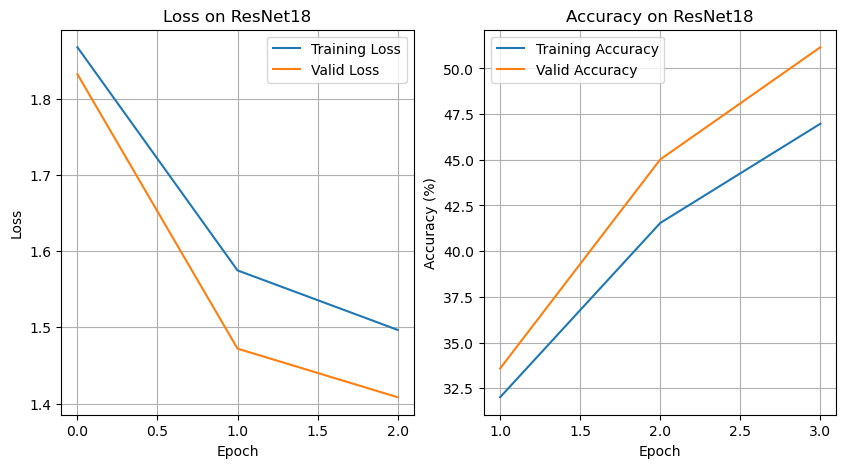

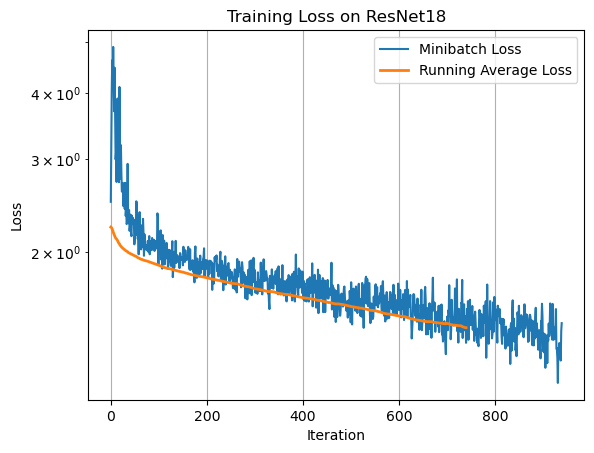

Model: ResNet18
Test Loss: 1.3976
Test Accuracy (Overall): 51.00%

Test Accuracy of Airplane: 51% (511/1000)
Test Accuracy of      Car: 77% (777/1000)
Test Accuracy of     Bird: 29% (293/1000)
Test Accuracy of      Cat: 30% (307/1000)
Test Accuracy of     Deer: 35% (357/1000)
Test Accuracy of      Dog: 53% (533/1000)
Test Accuracy of     Frog: 39% (399/1000)
Test Accuracy of    Horse: 48% (486/1000)
Test Accuracy of     Ship: 79% (796/1000)
Test Accuracy of    Truck: 64% (641/1000)
Training ResNet34 for 3 epochs with initial learning rate 0.1...
Epoch: 001/003 | Current Learning Rate: 0.100000
Epoch: 001/003 | Batch 0000/0313 | Loss: 2.4389
Epoch: 001/003 | Batch 0050/0313 | Loss: 2.2942
Epoch: 001/003 | Batch 0100/0313 | Loss: 2.3113
Epoch: 001/003 | Batch 0150/0313 | Loss: 2.1277


KeyboardInterrupt: 

In [43]:
def train_all_resnet_models():
    resnet_models = {
        "ResNet18": (ResNet18(num_classes=10).to(device), 130, 0.1),
        "ResNet34": (ResNet34(num_classes=10).to(device), 130, 0.1),
        "ResNet50": (ResNet50(num_classes=10).to(device), 130, 0.1),
        "ResNet101": (ResNet101(num_classes=10).to(device), 130, 0.1),
        "ResNet152": (ResNet152(num_classes=10).to(device), 130, 0.01),
    }
    
    
    
    log_dicts = []

    for model_name, (model, num_epochs, initial_lr) in resnet_models.items():
        print(
            f"Training {model_name} for {num_epochs} epochs with initial learning rate {initial_lr}..."
        )
        # optimizer = optim.SGD(
        #     model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4
        # )
        # loss_fn = nn.CrossEntropyLoss()
        # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
        optimizer = optim.SGD(
            model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=6, verbose=True
        )
        loss_fn = nn.CrossEntropyLoss()
        log_dict = train(
            model,
            train_loader,
            valid_loader,
            num_epochs=num_epochs,
            optimizer=optimizer,
            loss_fn=loss_fn,
            scheduler=scheduler,
            model_name=model_name,
        )
        log_dicts.append(log_dict)
        model.load_state_dict(torch.load(f"{model_name}_cifar.pt"))
        plot_training_metrics(log_dict, num_epochs)
        test(model, test_loader, model_name)
        # plot_images_with_predictions(model, test_loader, classes, model_name)

    return log_dicts


# 开始训练所有模型
log_dicts = train_all_resnet_models()

/tmp/ipykernel_36175/437072118.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


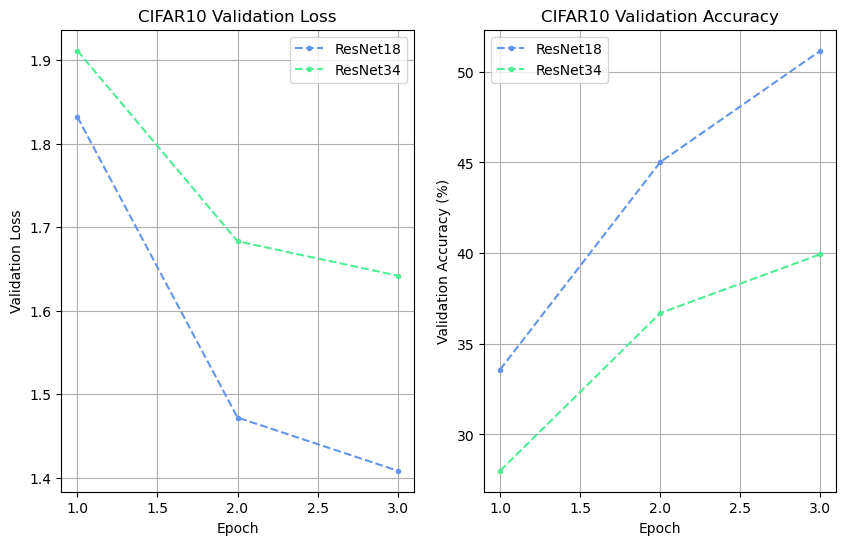

In [ ]:
plot_resnet_compare(log_dicts)